# Simple neural network with Equinox and Optax

In [1]:
import jax
import jax.numpy as np
import jax.random as jr
import optax
import einops
import equinox as eqx 

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### We load the mnist handwritten digit dataset:
- x_train: (60000,28,28) array of images (28*28 resolution)
- x_test: (10000,28,28) array of images (28*28 resolution)

- y_train: (60000) array of labels (integers 0-9)
- y_test: (10000) array of labels (integers 0-9)

- y_train_1hot: (60000,10) array of one hot encoded labels
- y_test_1hot: (10000,10) array of one hot encoded labels


In [2]:
# We only use tensorflow for loading the mnist dataset 
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train_flat = einops.rearrange(x_train,"batches w h -> batches (w h)") / 255.0
x_test_flat = einops.rearrange(x_test,"batches w h -> batches (w h)") / 255.0
y_train_1hot = jax.nn.one_hot(y_train,num_classes=10,axis=-1)
y_test_1hot = jax.nn.one_hot(y_test,num_classes=10,axis=-1)

2024-02-19 09:47:17.511621: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 09:47:17.511648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 09:47:17.512437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 09:47:18.369523: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Define a neural network by inheriting from `eqx.Module`:
- This simplifies the syntax of JAX gradient calculations
- `eqx.Module`:
    - Classes inheriting from `eqx.Module` will be a python `dataclass`, meaning you have to define any self.variables at the class level, i.e. the `layers: list` before the `__init__`. This just forces you to be a bit cleaner in your software engineering
    - See https://docs.kidger.site/equinox/api/module/module/
- `eqx.nn`:
    - `eqx.nn.Linear` constructs a linear layer, but there are many other layers included in this library
    - See https://docs.kidger.site/equinox/api/nn/linear/
- Notice that we also have some `jax.nn` functions. In general, any pure jax function will work in an eqx.Module model, and will be treated correctly during training

In [3]:
class SimpleNetwork(eqx.Module):
    layers: list

    def __init__(self,input_size,hidden_size,output_size,key):
        key1, key2 = jax.random.split(key, 2)
        self.layers = [
            eqx.nn.Linear(input_size,hidden_size,key=key1),
            jax.nn.relu,
            eqx.nn.Linear(hidden_size,output_size,key=key2),
            jax.nn.softmax
        ]
    
    def __call__(self,x):
        for L in self.layers:
            x = L(x)
        return x

### `loss` function doesn't need explicit model parameters as inputs

In [4]:
@eqx.filter_value_and_grad
def loss(model,x,y):
    y_predicted = jax.vmap(model,in_axes=0,out_axes=0,axis_name="BATCHES")(x)

    #print(y_predicted)
    #return np.mean((y_predicted-y)**2)
    return -np.mean(y*np.log(y_predicted))

### Training loop is a bit more involved now:
- the `@eqx.filter_jit` wrapper around the `make_step` function performs Just In Time compilation
    - this will run slower on the first call, but on every subsequent call will run much faster than normal python
- `optax.adam` is a more sophisticated optimiser than the one we wrote
    - the expression `optim.init(eqx.filter(model, eqx.is_array))` initialises the optimiser on the parts of model that are arrays
    - the optimiser also has it's own internal state (to keep track of momentum). This is passed around as the `opt_state` variable

In [13]:
def train(model,steps,key,LEARN_RATE=1e-3,BATCH_SIZE=32):

    optim = optax.adam(LEARN_RATE)
    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    loss_log = []
    
    @eqx.filter_jit
    def make_step(model,opt_state,X,Y):
        loss_value,grad = loss(model,X,Y)
        updates, opt_state = optim.update(grad, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
    
    #train_key = jr.fold_in(key,1)
    for i in tqdm(range(steps)):
        train_key = jr.fold_in(key,i)
        inds = jr.choice(train_key,np.arange(60000),(BATCH_SIZE,),replace=False)
        x = x_train_flat[inds]
        y = y_train_1hot[inds]
        #print(x.shape)
        
        model, opt_state, train_loss = make_step(model, opt_state, x, y)
        
        
        loss_log.append(train_loss)
        if i%10==0:
            tqdm.write("Loss at step "+str(i)+": "+str(train_loss))
    plt.plot(loss_log)
    plt.show()
    return model

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss at step 0: 0.23129778
Loss at step 10: 0.20113729
Loss at step 20: 0.16250508
Loss at step 30: 0.14718717
Loss at step 40: 0.12666811
Loss at step 50: 0.07449426
Loss at step 60: 0.059476893
Loss at step 70: 0.060595542
Loss at step 80: 0.06719347
Loss at step 90: 0.057093967
Loss at step 100: 0.08894007
Loss at step 110: 0.089366786
Loss at step 120: 0.05702744
Loss at step 130: 0.03153726
Loss at step 140: 0.031151308
Loss at step 150: 0.05384567
Loss at step 160: 0.038259313
Loss at step 170: 0.06501317
Loss at step 180: 0.050509673
Loss at step 190: 0.051974814
Loss at step 200: 0.05399394
Loss at step 210: 0.040573575
Loss at step 220: 0.032866076
Loss at step 230: 0.053656217
Loss at step 240: 0.018527383
Loss at step 250: 0.028726075
Loss at step 260: 0.041564744
Loss at step 270: 0.041526314
Loss at step 280: 0.025707064
Loss at step 290: 0.042811632
Loss at step 300: 0.024884013
Loss at step 310: 0.018526936
Loss at step 320: 0.027680684
Loss at step 330: 0.018082293
Loss

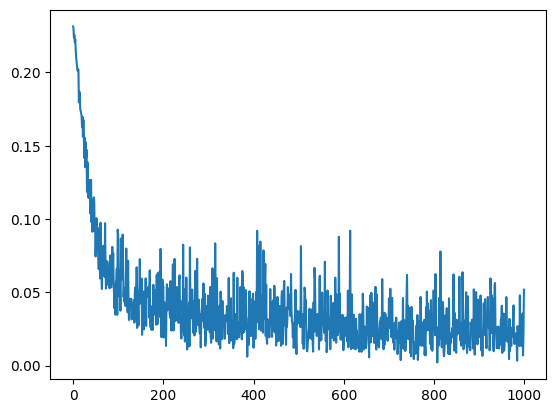

In [14]:
key = jr.PRNGKey(12345)
nn = SimpleNetwork(784,100,10,key)
nn = train(nn,1000,key)

### Let's evaluate our trained model on the test dataset
- A confusion matrix is a useful way to visualise this
    - each entry $C_{ij}$ counts how many times an image of class $i$ was labelled as class $j$
    - If our model is perfect, this matrix should be diagonal
    - It can be helpful to understand if there are two classes of images that are often confused

In [ ]:
y_test_predictions = np.argmax(jax.vmap(nn)(x_test_flat),axis=1) # By taking the maximum of the output probability distribution, we are forcing the model to discretely choose a number
confusion_matrix = np.zeros((10,10))
for i in range(len(y_test)):
    confusion_matrix = confusion_matrix.at[y_test[i],y_test_predictions[i]].set(confusion_matrix[y_test[i],y_test_predictions[i]]+1)




In [ ]:
plt.imshow(confusion_matrix)